# Segmenting and Clustering Neighborhoods in Toronto

## Introduction

This notebook is a part of my Applied Data Science Professional Certification from IBM at Coursera.

In this lab I will explore and cluster the neighborhoods in Toronto.

To do this first I will use Web Scraping methods and get information about neighborhoods in Toronto from [wikipedia page](https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050)

Secondly I will need to get latitude and longitude values which corresponds to the neighborhoods in Toronto. This could be done using  Geocoder Python package or by using GeoSpatial Dataset provided by IBM named `Geospatial_Coordinates`

As a last part in this project I will  use the Foursquare API to explore neighborhoods in Toronto. I will also use the explore function to get the most common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. I will use the k-means clustering algorithm to complete this task.

Finally, I will use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

## Table of Contents

[1. WebScraping using BeautifulSoup](#webscraping)
<br>
[2. GeoSpatial DataSet](#geodata)
<br>
[3. Explore the neighborhoods in Toronto](#explore)
<br>
[4. Explore venues in Toronto using Foursquare](#foursquare)
<br>
[5. Analyze Each Neighborhood](#analyze)
<br>
[6. Cluster Neighborhoods](#cluster)
<br>
[7. Examine Clusters](#examine)
<br>
[8. Conclusion](#conclusion)

**Before I will start I need to import necessary libraries**

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup 
import requests 

import seaborn as sns
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install geopy
from geopy.geocoders import Nominatim 

import json

from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 1. WebScraping using BeautifulSoup <a name='webscraping'></a>

Download the contents of the web page

**NOTE:** To process this task I will use the old version of wikipedia website containings `List of postal codes of Canada: M`

In [2]:
url = 'https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050'

Get the contents of the webpage in text format and store in a variable called `data`

In [3]:
data = requests.get(url).text

Create BeautifulSoup object

In [4]:
soup = BeautifulSoup(data, 'lxml')

In [5]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"3d138eba-0d6e-4cbb-9991-060dce3faca3","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":1019189119,"wgRevisionId":945633050,"wgArticleId":539066,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description is different from Wikidata","Communicat

After quick observations I can see that the `table` belong to the class `wikitable sortable`

In [6]:
table = soup.find('table', {'class': 'wikitable sortable'})

In [7]:
print(table.tr.text)


Postcode
Borough
Neighbourhood



Now I will create (for now it will be empty) dataframe and called it `df`

In [8]:
columns_name = ['PostalCode', 'Borough', 'Neighborhood']
df = pd.DataFrame(columns = columns_name)
df

,PostalCode,Borough,Neighborhood


In [9]:
for row in table.find_all('tr'): # in html table row is represented by the tag <tr>
    row_data=[]
    for data in row.find_all('td'): # in html a column is represented by the tag <td>
        row_data.append(data.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

In [10]:
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Etobicoke,Islington Avenue


In [11]:
df.shape

(287, 3)

**Data cleaning**

I need only process the cells that have an assigned borough and ignore cells with a borough that is Not assigned.

1) remove value from `Borough` where value = `'Not assigned'`

In [12]:
boro_value = df [df['Borough'] == 'Not assigned'].index
df.drop(boro_value, inplace=True)

In [13]:
df.head(10)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [14]:
df.shape

(210, 3)

2) In situation that in column Neighborhood value is `Not assigned`, it will take the value from Borough column

In [15]:
df.loc[df['Neighborhood'] =='Not assigned' , 'Neighborhood'] = df['Borough']

In [16]:
df.head(10)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
9,M9A,Etobicoke,Islington Avenue
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


In [17]:
df.shape

(210, 3)

3) After two above steps I would like to check if in my df exists any` Not assigned` value

In [18]:
exists = 'Not assigned' in df
exists

False

4) If PostalCode appear more than once and has more than one neighborhood then these two rows will be combined into one row with the neighborhoods separated with a comma

In [19]:
results = df.groupby(['PostalCode', 'Borough'], sort=False).agg(', '.join)

In [20]:
df_toronto = results.reset_index()
df_toronto.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [21]:
df_toronto.shape

(103, 3)

## 2. GeoSpatial DataSet <a name='geodata'></a>

In order to perform second step in this project I will use GeoSpatial DataSet and according to this I will use csv file already provided - `Geospatial_Coordinates.csv`

In [22]:
geo = pd.read_csv('Geospatial_Coordinates.csv')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
geo.shape

(103, 3)

As we can see above the data provide information about coordinates  - we have  Latitude and  	Longitude for each Postal Code.

Now I will merge two dataframes into one which contains full informations about neighborhoods in Toronto. 

In [24]:
geo.columns = ['PostalCode', 'Latitude', 'Longitude']
geo.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [25]:
df_full = pd.merge(df_toronto, geo, on='PostalCode')
df_full.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


In [26]:
df_full.shape

(103, 5)

## 3. Explore the neighborhoods in Toronto <a name='explore'></a>

In [27]:
print('In Toronto there are {} Boroughs.'.format(df_full['Borough'].nunique()))

In Toronto there are 10 Boroughs.


In [28]:
print('The Boroughs in Toronto are: \n{}'.format(df_full['Borough'].unique()))

The Boroughs in Toronto are: 
['North York' 'Downtown Toronto' 'Etobicoke' 'Scarborough' 'East York'
 'York' 'East Toronto' 'West Toronto' 'Central Toronto' 'Mississauga']


In this project it is voluntariness which borough to choose for analysis, so I decided to choose all Boroughs in  Toronto 

In [29]:
toronto_df = df_full
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


Let's visualize above table in more insight way

In [30]:
num_neigh = toronto_df.groupby('Borough')['Neighborhood'].count().sort_values(ascending=False)
num_neigh

Borough
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Mississauga          1
Name: Neighborhood, dtype: int64

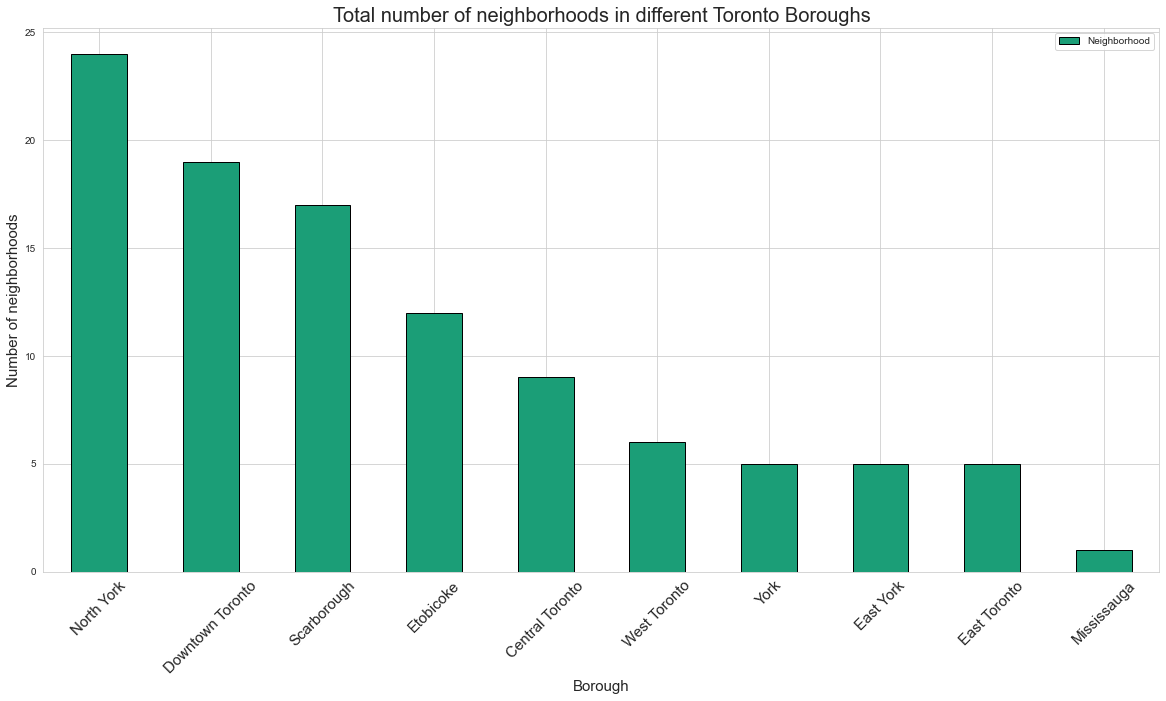

In [31]:
sns.set_style('whitegrid')
sns.set_palette('Dark2')
plt.figure(figsize=(20,10))
plt.ylabel('Number of neighborhoods', size=15)
plt.xlabel('Boroughs', size=15)
plt.title('Total number of neighborhoods in different Toronto Boroughs', size=20)
num_neigh.plot(kind='bar', edgecolor='black')
plt.xticks(rotation=45, size=15)
plt.legend()
plt.show()

**Now let's use Folium package to visualize map of Toronto with neighborhoods**

1) First I will use geopy library to get the latitude and longitude values of Toronto

In [32]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


2) I will create a map of Toronto with neighborhoods superimposed on top

In [33]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'],
                                          toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#ff1a1a',
    fill_opacity=0.7,
    parse_html=False).add_to(toronto_map)
    
toronto_map

## 4. Explore venues in Toronto using Foursquare <a name='foursquare'></a>

I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them

1) Define Foursquare Credentials and Version

In [34]:
CLIENT_ID = 'OXY5WDQUX1S0BGW54I3DDGVYZA5NFRU04RAWIYTP1NJVDLPT' # your Foursquare ID
CLIENT_SECRET = 'HOKXYB52GO5EZR1NO5FSJOELTWRLXH2GT2P2APTYHM2CLHEQ' # your Foursquare Secret
VERSION = '20180605' 
LIMIT = 100 
radius = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OXY5WDQUX1S0BGW54I3DDGVYZA5NFRU04RAWIYTP1NJVDLPT
CLIENT_SECRET:HOKXYB52GO5EZR1NO5FSJOELTWRLXH2GT2P2APTYHM2CLHEQ


2) Create a function to repeat the same process of getting venues to all the neighborhoods in Toronto

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

3) Now write the code to run the above function on each neighborhood and create a new dataframe called `toronto_venues`

In [36]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                latitudes=toronto_df['Latitude'],
                                longitudes=toronto_df['Longitude'])

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights, Lawrence Manor
Queen's Park
Islington Avenue
Rouge, Malvern
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park
Highland Creek, Rouge Hill, Port Union
Flemingdon Park, Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Downsview North, Wilson Heights
Thorncliffe Park
Adelaide, King, Richmond
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto
Harbourfront East, Toronto Islands, Union Station
Little Portugal, Trinity
East Birchmount Park, Ionview, Kennedy Park
Bayview Village
CFB Toronto, Downsview East
The Danforth West,

4) Expolore new dataframes - `toronto_venues`

In [37]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [38]:
toronto_venues.shape

(2007, 7)

In [39]:
toronto_venues.groupby('Neighborhood')['Venue Category'].count().sort_values(ascending=False).to_frame()

,Venue Category
Neighborhood,
"Adelaide, King, Richmond",100
"Commerce Court, Victoria Hotel",100
"Ryerson, Garden District",100
"Harbourfront East, Toronto Islands, Union Station",100
"First Canadian Place, Underground city",100
...,...
"Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Queensway East, Royal York South East, Sunnylea",1
"Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park",1
"Highland Creek, Rouge Hill, Port Union",1


In [40]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 259 uniques categories.


**Summary:** 
- dataframe `toronto_venues` contains 2007 rows and 7 columns
- In Toronto we have 259 different categories of venues 
- the number of  different venues in each neighborhoods differ in a range between 1 up to 100 

## 5. Analyze Each Neighborhood <a name='analyze'></a>

1) I will use one hot encoding which is preparation for machine learning algorithm I will use later 

In [41]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

toronto_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I want to move column `Neighborhood` at the beginning of toronto_onehot so first I need to get exact location of this column

In [42]:
toronto_onehot.columns.get_loc('Neighborhood')

181

The function `change_column_order` will help me to move column Neighborhood at the beginning of desired dataframe.

It takes 3 parameters:
- df
- col_name
- index which is number of desired index for new location

In [43]:
def change_column_order(df, col_name, index):
    cols = df.columns.tolist()
    cols.remove(col_name)
    cols.insert(index, col_name)
    return df[cols]

In [44]:
toronto_onehot = change_column_order(toronto_onehot, 'Neighborhood', 0)
toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2) Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [45]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,"Woodbine Gardens, Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
toronto_grouped.shape

(100, 259)

3) Let's print each neighborhood along with the top 10 most common venues

First, let's write a function to sort the venues in descending order.

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Secondly, let's create the new dataframe - `toronto_venues_sorted` and display the top 10 venues for each neighborhood.


In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Sandwich Place,Gym,Clothing Store,Sushi Restaurant,Restaurant,Japanese Restaurant,Deli / Bodega,Steakhouse
1,Agincourt,Skating Rink,Breakfast Spot,Lounge,Clothing Store,Latin American Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Intersection,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Beer Store,Sandwich Place,Coffee Shop,Fast Food Restaurant,Pizza Place,Drugstore,Donut Shop,Deli / Bodega
4,"Alderwood, Long Branch",Pizza Place,Pub,Coffee Shop,Sandwich Place,Playground,Skating Rink,Dance Studio,Yoga Studio,Department Store,Dessert Shop


In [49]:
toronto_venues_sorted.shape

(100, 11)

## 6. Cluster Neighborhoods <a name='cluster'></a>

Run `k-means` to cluster the neighborhood into 5 clusters.

In [50]:
# first I need to drop column Neighborhood 

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [51]:
k_clusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [52]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

toronto_merged = toronto_merged.join(toronto_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#drop PostalCode column
toronto_merged = toronto_merged.drop('PostalCode', 1)

toronto_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,3.0,Food & Drink Shop,Fast Food Restaurant,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,North York,Victoria Village,43.725882,-79.315572,1.0,Grocery Store,Coffee Shop,Nail Salon,Hockey Arena,Portuguese Restaurant,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner
2,Downtown Toronto,Harbourfront,43.654260,-79.360636,1.0,Coffee Shop,Bakery,Park,Pub,Café,Restaurant,Greek Restaurant,Spa,Bank,Mexican Restaurant
3,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Coffee Shop,Miscellaneous Shop,Vietnamese Restaurant,Furniture / Home Store,Boutique,Drugstore,Eastern European Restaurant,Department Store
4,Downtown Toronto,Queen's Park,43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Burrito Place,Yoga Studio,Bar,Sandwich Place,Salad Place,Burger Joint,Restaurant,Café


Finally, let's visualize the resulting clusters

I found there is no data available for some neighbourhood, so I will drop that row and also change data types for column 'Cluster Labels'

In [53]:
toronto_merged=toronto_merged.dropna()

In [54]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [55]:
toronto_cluster = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color=rainbow[int(cluster-1)],
    fill=True,
    fill_color=rainbow[int(cluster-1)],
    fill_opacity=0.7).add_to(toronto_cluster)

toronto_cluster

## 7. Examine Clusters <a name='examine'></a>

I can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

**Cluster 1**

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Don Mills North,Café,Baseball Field,Caribbean Restaurant,Japanese Restaurant,Gym,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
11,"Cloverdale, Islington, Martin Grove, Princess ...",Middle Eastern Restaurant,Yoga Studio,College Gym,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
50,Humber Summit,Gym,Restaurant,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
51,"Cliffcrest, Cliffside, Scarborough Village West",American Restaurant,Motel,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
53,Downsview Central,Home Service,Food Truck,Baseball Field,Doner Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Yoga Studio,Dessert Shop
57,"Emery, Humberlea",Baseball Field,Food Service,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop
62,Roselawn,Garden,Health & Beauty Service,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
98,"The Kingsway, Montgomery Road, Old Mill North",River,Pool,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
101,"Humber Bay, King's Mill Park, Kingsway Park So...",Baseball Field,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop


**Cluster 2**

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Grocery Store,Coffee Shop,Nail Salon,Hockey Arena,Portuguese Restaurant,Yoga Studio,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner
2,Harbourfront,Coffee Shop,Bakery,Park,Pub,Café,Restaurant,Greek Restaurant,Spa,Bank,Mexican Restaurant
3,"Lawrence Heights, Lawrence Manor",Clothing Store,Accessories Store,Coffee Shop,Miscellaneous Shop,Vietnamese Restaurant,Furniture / Home Store,Boutique,Drugstore,Eastern European Restaurant,Department Store
4,Queen's Park,Coffee Shop,Sushi Restaurant,Burrito Place,Yoga Studio,Bar,Sandwich Place,Salad Place,Burger Joint,Restaurant,Café
8,"Woodbine Gardens, Parkview Hill",Pizza Place,Pharmacy,Gastropub,Bank,Athletics & Sports,Flea Market,Gym / Fitness Center,Intersection,Drugstore,Donut Shop
...,...,...,...,...,...,...,...,...,...,...,...
96,"Cabbagetown, St. James Town",Coffee Shop,Bakery,Restaurant,Pizza Place,Italian Restaurant,Pub,Café,Bank,Taiwanese Restaurant,Sandwich Place
97,"First Canadian Place, Underground city",Coffee Shop,Sandwich Place,Café,Hotel,Gym,Japanese Restaurant,Asian Restaurant,Bank,Deli / Bodega,Restaurant
99,Church and Wellesley,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Coffee Shop,Gym,Fast Food Restaurant,Indian Restaurant,Mediterranean Restaurant,Burrito Place
100,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Smoke Shop,Brewery,Spa,Light Rail Station,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant


**Cluster 3**

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Highland Creek, Rouge Hill, Port Union",Bar,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop


**Cluster 4**

In [59]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Food & Drink Shop,Fast Food Restaurant,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
21,Caledonia-Fairbanks,Park,Women's Store,Pool,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop
35,East Toronto,Convenience Store,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
52,"Newtonbrook, Willowdale",Park,Yoga Studio,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
64,Weston,Park,Yoga Studio,Department Store,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
66,York Mills West,Convenience Store,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
77,"Kingsview Village, Martin Grove Gardens, Richv...",Park,Mobile Phone Shop,Sandwich Place,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
83,"Moore Park, Summerhill East",Tennis Court,Park,Playground,Trail,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
85,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Intersection,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
91,Rosedale,Park,Playground,Trail,Yoga Studio,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store


**Cluster 5**

In [60]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Rouge, Malvern",Fast Food Restaurant,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant


## 8. Conclusion <a name='conclusion'></a>

**Summary:**

Based on the defining categories by machine learning algorithm k-means clustering, I am not able to assign a name to each cluster because they were split without any visible features. However, the tasks for this notebook was succesfully performed. Using WebScrapping methods the data was took from wikipedia page and merged with the GeoSpatial Dataset. After that Foursquare API was run. I explored neighborhoods in Toronto City and based on that information performed machine learning algorithm. Working on this notebook was really interesting and educational journey. 